# scikit-hts showcase: [M5 kaggle competition](https://www.kaggle.com/c/m5-forecasting-accuracy)

In this notebook we will use the data from the Kaggle competiton to perform some hierarchical forecasting. The problem is particularly well suited for the library, as there is a clear hierarchical relationship between each of the series: we have states, stores, categories, departments, and items; sum of sales of items resolve to departments, which summed resolved to categories and so forth.


We will however limit the scope of the forecasting task to producing forecasts at the 
department level, rather than going to the full extent and forecasting for single items. 

The reasons for this is that this notebook is designed for exemplification purposes, rather than providing a workable solution for the challenge.

In [3]:

import os
from pprint import pprint
import importlib

import pandas
import numpy
import matplotlib
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from pandas.core.common import SettingWithCopyWarning


import warnings

warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

%matplotlib inline
%load_ext autoreload
%autoreload 2


%matplotlib inline

# Download the raw files into this directory
data = '../data/raw/' 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
!ls ../data/raw

calendar.csv		    sample_submission.csv
sales_train_validation.csv  sell_prices.csv


## Transform data in the format required by scikit-hts

We will build a hierarchy tree that will look like the following:


    Level                             Node Key                          # of nodes

      1                                total                                  1

      2                 CA               TX                   WI              3

      3           CA_1 CA_2 CA_3   TX_1 TX_2 TX_3        WI_1 WI_2 WI_3       6

      4      CA_1_HOBBIES_1 ....   TX_1_HOBBIES_1...    ... WI_3_FOODS_3     70
      ...
      
      
 
The steps are the following:

1. Transform dataset into a column oriented one
2. Create the hierarchy representation as a dictionary
 
For a complete description of how that is done under the hood, and for a sense of what the API accepts, see [scikit-hts' docs](https://scikit-hts.readthedocs.io/en/latest/hierarchy.html)

In [5]:
train = pandas.read_csv(os.path.join(data, 'sales_train_validation.csv'), 
                        encoding='utf-8', 
                        engine='c').drop('item_id', 1)

# Ensures uniqueness of category, dept, and item across hierarchie
train['cat_id']  = (train['store_id'] + '_' + train['cat_id'])
train['dept_id'] = (train['store_id'] + '_' + train['dept_id'])

In [6]:
calendar = pandas.read_csv(os.path.join(data, 'calendar.csv'))

day_cols = [col for col in train.columns if col.startswith('d_')]
idx = [int(col.split('d_')[1]) for col in day_cols]

# will be useful later
train_date_id = pandas.to_datetime(calendar[calendar.d.apply(lambda x: int(x.split('d_')[1])).isin(idx)].date)

In [7]:
def transpose(column, index, day_col):
    """
    Turn the row oriented time series into a column oriented one 
    """
    ts = []
    new_cols = train[column].unique()
    
    for value in new_cols:
        value_ts = train[train[column] == value]
        vertical = value_ts[day_col].sum().T
        vertical.index = index
        ts.append(vertical)
    return pandas.DataFrame({k: v for k, v in zip(new_cols, ts)})
    

In [8]:
state_ts = transpose('state_id', train_date_id, day_cols)
store_ts = transpose('store_id', train_date_id, day_cols)
cat_ts = transpose('cat_id', train_date_id, day_cols)
dept_ts = transpose('dept_id', train_date_id, day_cols)

In [ ]:
df = pandas.concat([state_ts, store_ts, cat_ts,dept_ts], 1)

# Total column is the root node -- the sum of of all demand across all stores (we have data on, at least)
df['total'] = df['CA'] + df['TX'] + df['WI']

df.head()

In [12]:
states = train.state_id.unique()
stores = train.store_id.unique()
depts = train.dept_id.unique()
cats = train.cat_id.unique()
itmes = train.id.unique()

# Here we build the tree as a dictionary. Each node (key in dict) has a list of 
# children value in dict, which in turn may also be a key in the dict, and have 
# children as well 
total = {'total': list(states)}
state_h = {k: [v for v in stores if v.startswith(k)] for k in states}
store_h = {k: [v for v in cats if v.startswith(k)] for k in stores}
dept_h = {k: [v for v in depts if v.startswith(k)] for k in cats}

In [ ]:
hierarchy = {**total, **state_h, **store_h, **dept_h}

### A small digression 

For exemplification purposes, here's what the hierarchy tree looks like. You are unlikely to need to build it yourself, it is
instead built by the library automatically

In [ ]:
from hts.hierarchy import HierarchyTree

ht = HierarchyTree.from_nodes(nodes=hierarchy, df=df)

print(f'Root node: key: {ht.key}, children: {[k.key for k in ht.children]}')

for child in ht.children:
    print(f'{child.key} node\'s children: {[c.key for c in child]} ')

Let's print the tree from the California node:

In [ ]:
print(ht.children[0].key)

print(ht.children[0])

You see the point. The hierarchy tree is recursively defined, and you can inspect any of the data of those nodes. For instance:

In [ ]:
# observe the recursive structure
print(f'Node: {ht.children[0].children[2].children[2].key}, item: ')
ht.children[0].children[2].children[2].item

## On to the fun part

We will fit Facebook's prophet to each of the nodes defined in our hierarchy tree, and then
reconcile them using the (simplest) [optimal reconciliation approach](https://otexts.com/fpp2/reconciliation.html), namely ordinary least squares.



In [14]:
from hts import HTSRegressor

clf = HTSRegressor(model='prophet', revision_method='OLS')
model = clf.fit(df, hierarchy)


ERROR:hts.hierarchy.utils:h3-py must be installed for geo hashing capabilities
Fitting base model for node : WI_3_FOODS_3: 100%|██████████| 114/114 [01:01<00:00,  1.84it/s]    


In [19]:
preds = model.predict(steps_ahead=28)

Generating base prediction for node: WI_3_FOODS_3: 100%|██████████| 114/114 [07:23<00:00,  3.89s/it]    


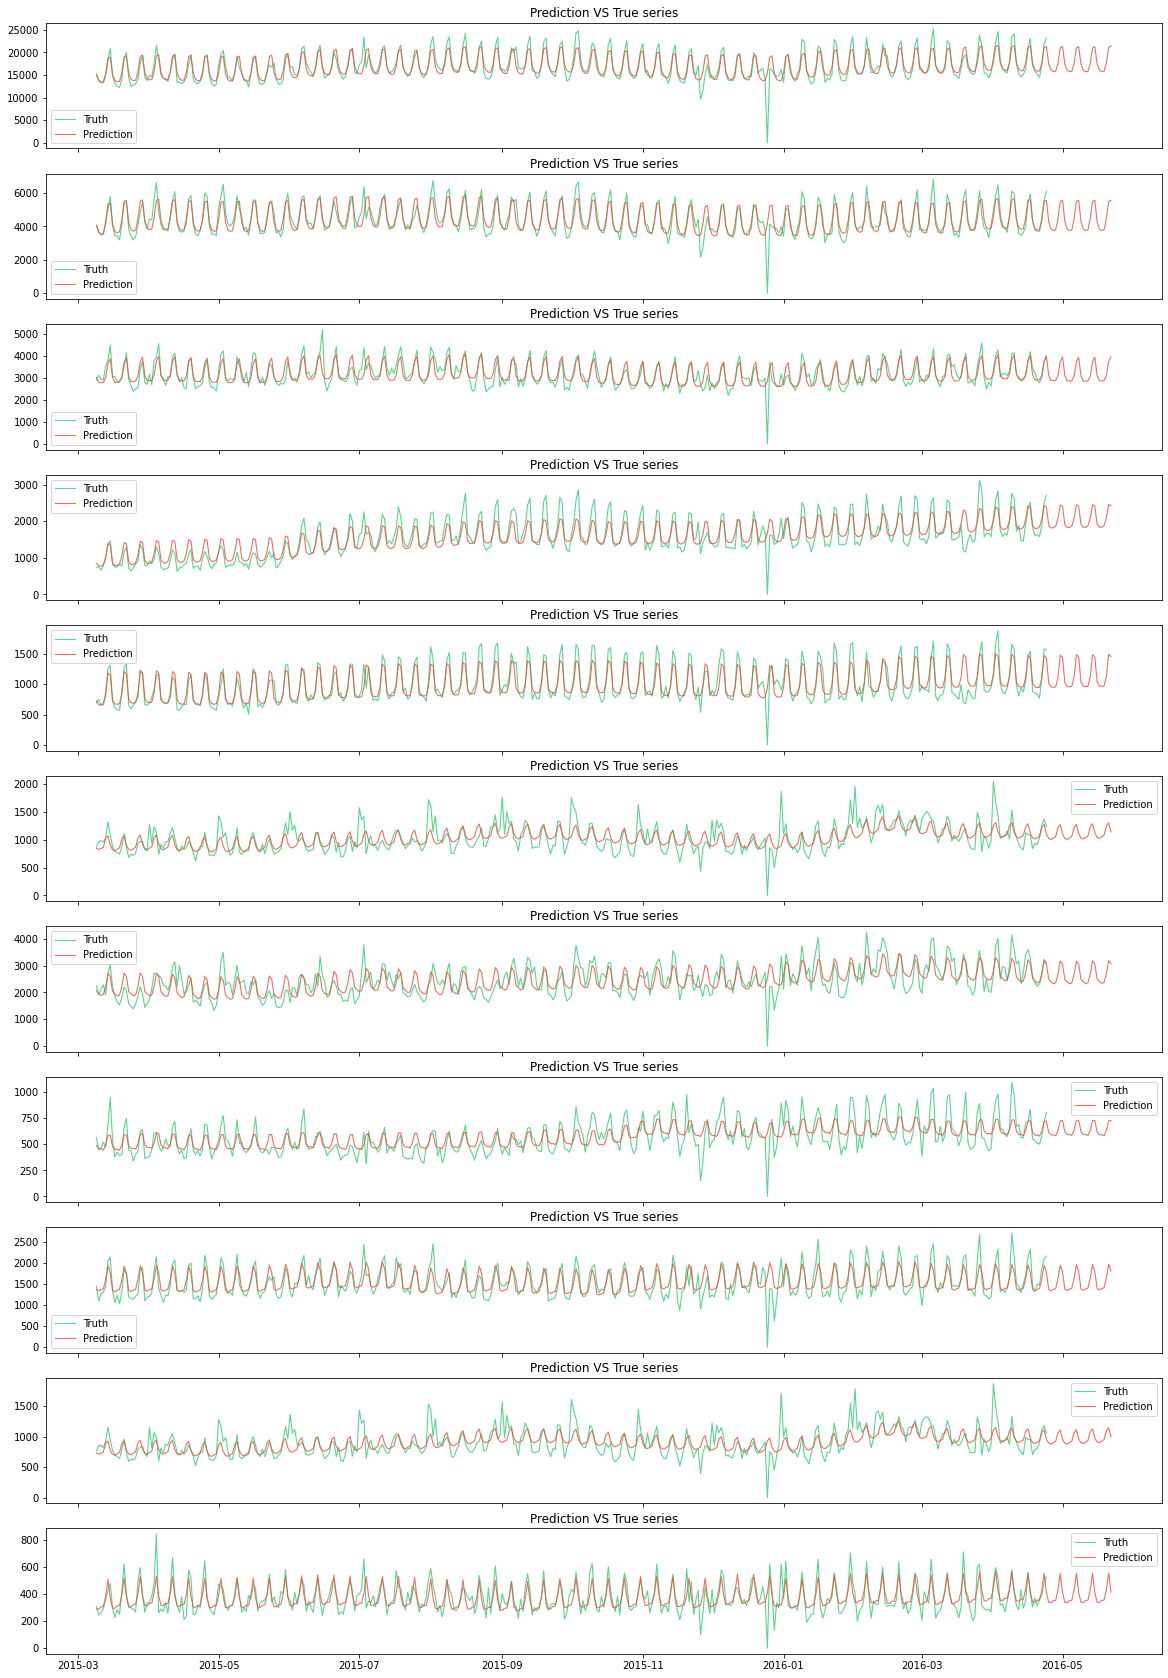

In [53]:
PLOT = ['CA', 
        'CA_1',
        'TX_1', 
        'CA_2_FOODS_3',
        'CA_2_HOUSEHOLD',
        'WI_2_HOUSEHOLD', 
        'WI_3_FOODS',
        'WI_1_FOODS_2', 
        'WI_1_FOODS_3',
        'WI_2_HOUSEHOLD_1',
        'WI_1_HOBBIES_1',
       ]

fig, axs = plt.subplots(len(PLOT), figsize=(20, 30), sharex=True)
ax.grid(alpha=0.75)

dts = preds[PLOT_FROM:].index

for i, group in enumerate(PLOT):
    axs[i].plot(df[PLOT_FROM:][group], 
            lw=1.1, 
            color='#2ecc71', 
            alpha=0.8, 
            label='Truth')
    axs[i].plot(preds[PLOT_FROM:][group], 
            lw=1.1,
            color='#e74c3c', 
            alpha=0.8, 
            label='Prediction')
    axs[i].legend()
    axs[i].set_title('Prediction VS True series')

**TODO**

- Benchmark against vanilla Prophet 
- Benchmark different reconciliation approaches
- Explanation of reconcialiation steps
- Train with exogenous variables